In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import pickle
from dask.diagnostics import ProgressBar
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
rides = pd.read_csv('../data/riders_cleaned.csv.gz', usecols = ['starttime', 'tripduration', 'gender', 'season', 'dayofweek','usertype','birth year'])

/Users/danielchoy/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
rides.head(10)

,tripduration,starttime,usertype,birth year,gender,season,dayofweek
0,362,2017-09-01 00:00:17,Subscriber,1993,1,fall,Friday
1,188,2017-09-01 00:00:21,Subscriber,1988,1,fall,Friday
2,305,2017-09-01 00:00:25,Subscriber,1969,1,fall,Friday
3,223,2017-09-01 00:00:52,Subscriber,1993,1,fall,Friday
4,758,2017-09-01 00:01:01,Subscriber,1987,1,fall,Friday
5,2089,2017-09-01 00:01:20,Subscriber,1975,2,fall,Friday
6,121,2017-09-01 00:01:22,Subscriber,1990,1,fall,Friday
7,408,2017-09-01 00:01:39,Subscriber,1961,1,fall,Friday
8,485,2017-09-01 00:01:41,Subscriber,1984,1,fall,Friday
9,220,2017-09-01 00:01:40,Subscriber,1992,1,fall,Friday


#### Gender

In [7]:
genders = ['Unknown', 'Male', 'Female']
y_pos = [0, 1, 2]
trip_counts = rides.groupby(['gender','usertype'])[['gender']].count().rename(columns={'gender':'counts'}).reset_index()
trip_counts['genders'] = trip_counts['gender'].apply(lambda x: 'Unknown' if x == 0 else 'Male' if x == 1 else 'Female')
trip_counts['counts_mil'] = trip_counts['counts'] / 1000000

In [8]:
trip_counts

,gender,usertype,counts,genders,counts_mil
0,0,Customer,10162183,Unknown,10.162183
1,0,Subscriber,1277184,Unknown,1.277184
2,1,Customer,3263403,Male,3.263403
3,1,Subscriber,69848605,Male,69.848605
4,2,Customer,2043852,Female,2.043852
5,2,Subscriber,23694606,Female,23.694606


Text(0, 0.5, 'Trip Counts in Millions')

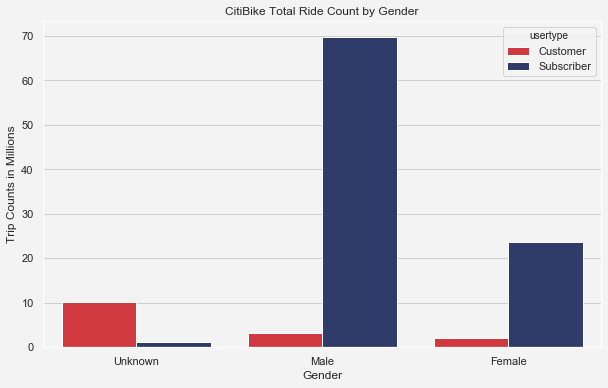

In [29]:
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
colors = ["#ea2029", "#263571", "#ea2029"]
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize = (10,6))
fig = sns.barplot(x = 'genders', y = 'counts_mil', hue = 'usertype', data = trip_counts)
fig.set_title('CitiBike Total Ride Count by Gender', fontsize=12)
fig.set_xlabel('Gender', fontsize=12)
fig.set_ylabel('Trip Counts in Millions', fontsize=12)

#### Number of Trips

In [11]:
rides['starttime'] = pd.to_datetime(rides['starttime'])
rides['date'] = rides['starttime'].dt.strftime('%Y-%m-%d')
rides['date'] = pd.to_datetime(rides['date'])
rides['month'] = rides['date'].dt.strftime('%Y-%m')
rides['year'] = rides['date'].dt.strftime('%Y')

In [12]:
rides['month2'] = rides.starttime.dt.month.apply(lambda x: 'Jan' if x == 1 else 'Feb' if x == 2 else \
    'Mar' if x == 3 else 'Apr' if x == 4 else 'May' if x == 5 else 'Jun' if x == 6 else 'Jul' if x == 7 else \
    'Aug' if x == 8 else 'Sep' if x == 9 else 'Oct' if x == 10 else 'Nov' if x == 11 else 'Dec' )

In [13]:
monthly = rides.groupby(['year','month2','usertype'])[['month2']].count().rename(columns={'month2':'counts'}).reset_index()

In [14]:
monthly['counts_mil'] = monthly['counts'] / 1000000

In [15]:
monthly

,year,month2,usertype,counts,counts_mil
0,2013,Aug,Customer,186056,0.186056
1,2013,Aug,Subscriber,815902,0.815902
2,2013,Dec,Customer,19381,0.019381
3,2013,Dec,Subscriber,424585,0.424585
4,2013,Jul,Customer,174916,0.174916
...,...,...,...,...,...
175,2020,Nov,Subscriber,1362408,1.362408
176,2020,Oct,Customer,546754,0.546754
177,2020,Oct,Subscriber,1702115,1.702115
178,2020,Sep,Customer,670551,0.670551


Text(0, 0.5, 'Number of Bike Rides (Million)')

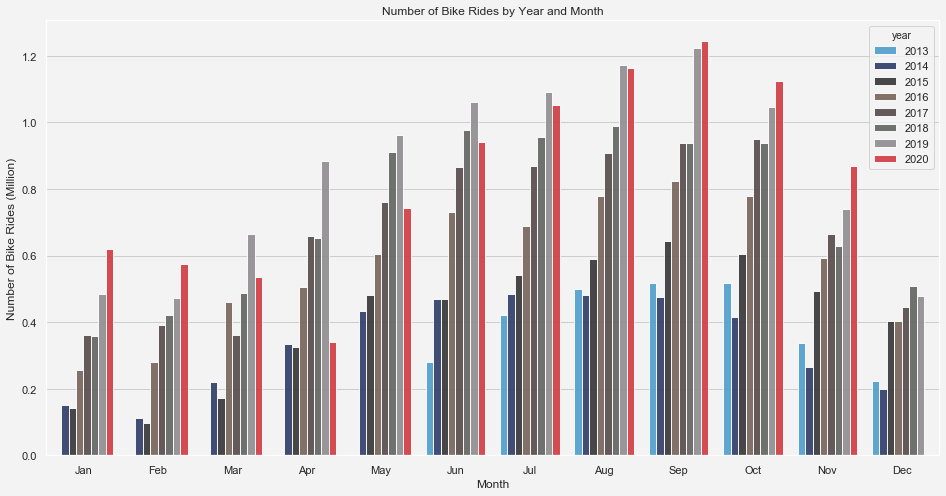

In [18]:
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
colors = ["#39a2e1","#263571","#343335","#7a6155","#574746","#60645f","#8e8c8e","#ea2029","#ea2029","#263571","#263571","#263571"]
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize = (16,8))
fig = sns.barplot(x = 'month2', y = 'counts_mil', hue = 'year', data = monthly, order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',\
                                                                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                 alpha = 0.9, ci = None)
fig.set_title('Number of Bike Rides by Year and Month', fontsize=12)
fig.set_xlabel('Month', fontsize=12)
fig.set_ylabel('Number of Bike Rides (Million)', fontsize=12)

In [19]:
monthly2 = monthly.groupby(['month2', 'usertype'])[['counts_mil']].mean().rename(columns={'counts_mil':'average'}).reset_index()

In [20]:
monthly2

,month2,usertype,average
0,Apr,Customer,0.141942
1,Apr,Subscriber,0.916361
2,Aug,Customer,0.299217
3,Aug,Subscriber,1.346794
4,Dec,Customer,0.044198
5,Dec,Subscriber,0.715167
6,Feb,Customer,0.036190
7,Feb,Subscriber,0.635279
8,Jan,Customer,0.031071
9,Jan,Subscriber,0.646896


Text(0, 0.5, 'Average Number of Bike Rides (Million)')

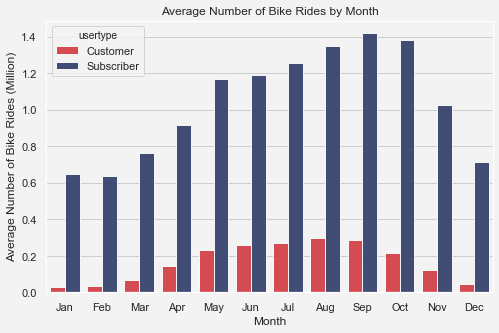

In [24]:
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
colors = ["#ea2029","#263571","#263571","#263571","#263571","#263571","#263571","#263571","#ea2029","#263571","#263571","#263571"]
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize = (8,5))
fig = sns.barplot(x = 'month2', y = 'average', hue = 'usertype', data = monthly2, order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',\
                                                                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                 alpha = 0.9, palette = None)
fig.set_title('Average Number of Bike Rides by Month', fontsize=12)
fig.set_xlabel('Month', fontsize=12)
fig.set_ylabel('Average Number of Bike Rides (Million)', fontsize=12)

#### Distribution of Duration

In [25]:
duration_mins = rides.loc[(rides.tripduration / 60 < 60)][['tripduration']]
duration_mins = duration_mins / 60

In [26]:
duration_mins

,tripduration
0,6.033333
1,3.133333
2,5.083333
3,3.716667
4,12.633333
...,...
110341608,26.450000
110341609,3.700000
110341610,2.716667
110341611,5.450000


Text(0, 0.5, 'Trip counts')

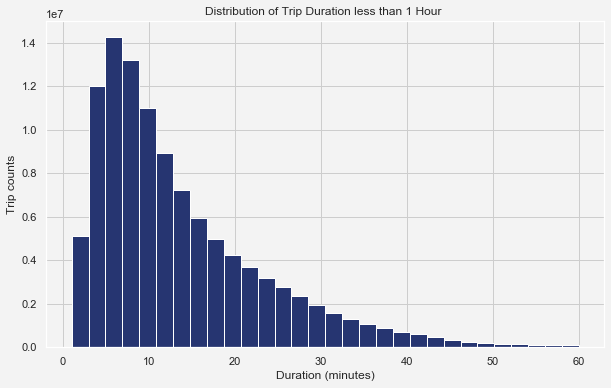

In [28]:
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
colors = ["#263571"]
sns.set_palette(sns.color_palette(colors))
duration_mins.hist(figsize = (10,6), bins = 30)
plt.tick_params(axis = 'both', which = 'major')
plt.title('Distribution of Trip Duration less than 1 Hour ')
plt.xlabel('Duration (minutes)')
plt.ylabel('Trip counts')

#### Weekdays vs Weekends

In [30]:
# Calculate trip counts per hour on weekdays and weekends
rides_sub = rides.loc[:, ['tripduration', 'starttime']]
rides_sub.index = rides_sub['starttime']
weekdays = rides_sub[rides_sub.index.weekday < 5]
weekends = rides_sub[rides_sub.index.weekday > 4]
weekday_ridesPerHr = weekdays.groupby(weekdays.index.hour).size()
weekend_ridesPerHr = weekends.groupby(weekends.index.hour).size()

In [31]:
rides['weekdays'] = rides.starttime.dt.weekday.apply(lambda x: 'Weekdays' if x <= 5 else 'Weekend')

In [32]:
weekdays_df = rides[['tripduration', 'weekdays', 'starttime']]

In [33]:
weekdays_df['start_hour'] = weekdays_df.starttime.dt.hour

/Users/danielchoy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
weekdays_df

,tripduration,weekdays,starttime,start_hour
0,362,Weekdays,2017-09-01 00:00:17.000,0
1,188,Weekdays,2017-09-01 00:00:21.000,0
2,305,Weekdays,2017-09-01 00:00:25.000,0
3,223,Weekdays,2017-09-01 00:00:52.000,0
4,758,Weekdays,2017-09-01 00:01:01.000,0
...,...,...,...,...
110341608,1587,Weekdays,2020-01-31 23:59:26.882,23
110341609,222,Weekdays,2020-01-31 23:59:32.641,23
110341610,163,Weekdays,2020-01-31 23:59:39.178,23
110341611,327,Weekdays,2020-01-31 23:59:49.231,23


In [35]:
weekdays_DF = weekdays_df.groupby(['start_hour', 'weekdays'])[['start_hour']].count().rename(columns={'start_hour':'counts'}).reset_index()

In [36]:
weekdays_DF['start_hour'] = weekdays_DF['start_hour'].astype(str)

In [37]:
weekdays_DF['counts_mil'] = weekdays_DF['counts'] / 1000000

In [38]:
weekdays_rides = weekdays_df[weekdays_df['weekdays'] == 'Weekdays']
weekend_rides = weekdays_df[weekdays_df['weekdays'] == "Weekend"]

Text(0, 0.5, 'Number of Bike Rides (Million)')

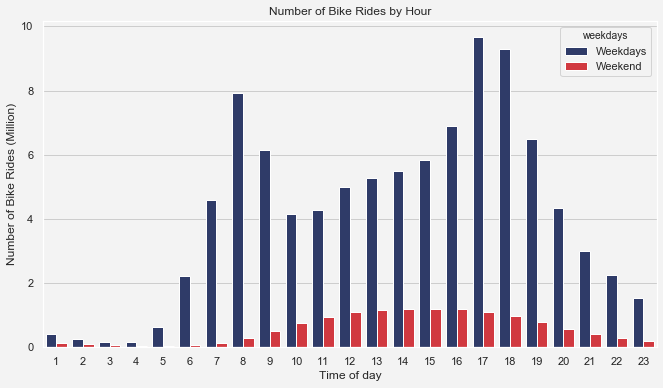

In [41]:
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
colors = ["#263571", '#ea2029']
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize = (11,6))
fig = sns.barplot(x = 'start_hour', y = 'counts_mil', hue = 'weekdays',
                  order = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14',\
                  '15','16','17','18','19','20','21','22','23'],data = weekdays_DF)
fig.set_title('Number of Bike Rides by Hour', fontsize=12)
fig.set_xlabel('Time of day', fontsize=12)
fig.set_ylabel('Number of Bike Rides (Million)', fontsize=12)

#### Basic summary data

In [39]:
rides.head(10)

,tripduration,starttime,usertype,birth year,gender,season,dayofweek,date,month,year,month2
0,362,2017-09-01 00:00:17,Subscriber,1993,1,fall,Friday,2017-09-01,2017-09,2017,Sep
1,188,2017-09-01 00:00:21,Subscriber,1988,1,fall,Friday,2017-09-01,2017-09,2017,Sep
2,305,2017-09-01 00:00:25,Subscriber,1969,1,fall,Friday,2017-09-01,2017-09,2017,Sep
3,223,2017-09-01 00:00:52,Subscriber,1993,1,fall,Friday,2017-09-01,2017-09,2017,Sep
4,758,2017-09-01 00:01:01,Subscriber,1987,1,fall,Friday,2017-09-01,2017-09,2017,Sep
5,2089,2017-09-01 00:01:20,Subscriber,1975,2,fall,Friday,2017-09-01,2017-09,2017,Sep
6,121,2017-09-01 00:01:22,Subscriber,1990,1,fall,Friday,2017-09-01,2017-09,2017,Sep
7,408,2017-09-01 00:01:39,Subscriber,1961,1,fall,Friday,2017-09-01,2017-09,2017,Sep
8,485,2017-09-01 00:01:41,Subscriber,1984,1,fall,Friday,2017-09-01,2017-09,2017,Sep
9,220,2017-09-01 00:01:40,Subscriber,1992,1,fall,Friday,2017-09-01,2017-09,2017,Sep


In [40]:
rides['day'] = rides['date'].dt.strftime('%d')

In [41]:
daily = rides.groupby(['day'])[['tripduration']].mean().rename(columns={'tripduration':'average'}).reset_index()

In [43]:
rides.describe()

,tripduration,gender
count,1.103416e+08,1.103416e+08
mean,1.025989e+03,1.129741e+00
std,1.307206e+04,5.659197e-01
min,6.000000e+01,0.000000e+00
25%,3.810000e+02,1.000000e+00
50%,6.440000e+02,1.000000e+00
75%,1.121000e+03,1.000000e+00
max,1.951005e+07,2.000000e+00


In [45]:
1.025989e+03 / 60

17.099816666666666

In [55]:
1.951005e+07 /60

325167.5

In [46]:
dailyrides = rides.groupby(['date'])[['date']].count().rename(columns={'date':'count'}).reset_index()

In [49]:
dailyrides.describe()

,count
count,2732.000000
mean,40388.584553
std,21321.406302
min,876.000000
25%,24560.500000
50%,36775.000000
75%,56220.500000
max,101462.000000


In [51]:
rides.groupby(['usertype'])[['usertype']].count().rename(columns={'usertype':'count'}).reset_index()

,usertype,count
0,Customer,15469438
1,Subscriber,94820395


In [52]:
15469438 + 94820395

110289833

In [53]:
94820395 / 110289833 * 100

85.97383133221355

In [56]:
age = rides.groupby(['birth year'])[['birth year']].count().rename(columns={'birth year': 'count'}).reset_index()

In [57]:
age

,birth year,count
0,1857,6
1,1858,1
2,1863,2
3,1873,43
4,1874,11
...,...,...
295,2001,1192
296,2002,594
297,2003,172
298,2004,54


In [66]:
83900 * 30

2517000

In [42]:
rides['day_of_week'] = rides['starttime'].dt.day_name()
rides['datehour'] = rides['starttime'].dt.hour

In [43]:
weekday_hourly = rides.groupby(['day_of_week','datehour']).size().reset_index(name='total_rides')


/Users/danielchoy/opt/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:1656: UserWarning: relplot is a figure-level function and does not accept target axes. You may wish to try lineplot
  warnings.warn(msg, UserWarning)


<Figure size 1008x504 with 0 Axes>

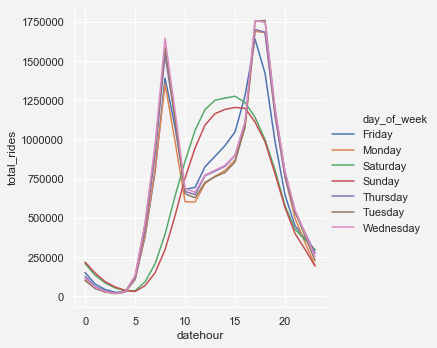

In [86]:
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3'})
colors = ["#39a2e1","#263571","#ea2029","#ea2029","#574746","#60645f","#8e8c8e","#ea2029"]
plt.figure(figsize = (14,7))
sns.relplot(ax = ax, x="datehour", y="total_rides", data = weekday_hourly, hue="day_of_week", kind="line")

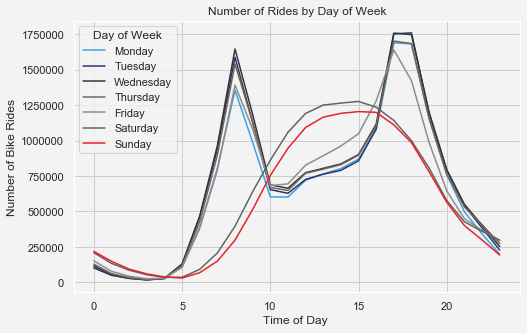

In [47]:
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
colors = ["#39a2e1","#263571","#343335","#7a6155","#8e8c8e","#60645f","#ea2029"]
plt.subplots(figsize = (8,5))
sns.set_palette(sns.color_palette(colors))
fig = sns.lineplot(x="datehour", y="total_rides", data = weekday_hourly, hue="day_of_week",
            hue_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], legend = False)
fig.set_title('Number of Rides by Day of Week', fontsize=12)
fig.set_xlabel('Time of Day ', fontsize=12)
fig.set_ylabel('Number of Bike Rides', fontsize=12)
plt.legend(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
           title = 'Day of Week')

In [3]:
rides_start = pd.read_csv('../data/riders_cleaned.csv.gz', 
                       usecols = ['start station id', 'start station name', 'start station latitude', \
                                  'start station longitude', 'tripduration']).reset_index()

In [4]:
rides_end = pd.read_csv('../data/riders_cleaned.csv.gz', 
                       usecols = ['end station id', 'end station name', 'end station latitude', \
                                  'end station longitude', 'tripduration'])

In [5]:
rides_start_df = rides_start.copy()

In [6]:
rides_start_df.index = rides_start['start station id']
rides_start_df['trip_count'] = rides_start.groupby('start station id')['start station id'].count()
rides_start_df['mean_duration'] = rides_start.groupby('start station id')['tripduration'].mean()
rides_start_df = rides_start_df.drop_duplicates()
rides_start_df.head()

,index,tripduration,start station id,start station name,start station latitude,start station longitude,trip_count,mean_duration
start station id,,,,,,,,
3331,0,362,3331,Riverside Dr & W 104 St,40.801343,-73.971146,72550,1554.021406
3101,1,188,3101,N 12 St & Bedford Ave,40.720798,-73.954847,84803,1066.021603
3140,2,305,3140,1 Ave & E 78 St,40.771404,-73.953517,226841,965.674389
236,3,223,236,St Marks Pl & 2 Ave,40.728419,-73.987140,364489,844.568920
3427,4,758,3427,Lafayette St & Jersey St,40.724305,-73.996010,184680,859.607207


In [ ]:
import folium
from matplotlib.colors import Normalize, rgb2hex
import matplotlib.cm as cm

norm = Normalize(rides_start_df['trip_count'].min(), rides_start_df['trip_count'].max())
# Get dark tileset from CartoBD (https://cartodb.com/basemaps)
tileset = r'http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png'

start_station_map = folium.Map(location = [40.74, -73.97], width = 600, height = 600,
                               tiles = tileset,
                               attr = '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, &copy; <a href="http://cartodb.com/attributions">CartoDB</a>',
                               zoom_start = 12)

for index, row in rides_start_df.iterrows():
    color = rgb2hex(cm.YlOrRd(norm(row['trip_count'])))
    folium.CircleMarker(location = [row['start station latitude'],
                                                row['start station longitude']],
                                    popup = row['start station id'],
                                    radius = row['mean_duration'] / 1000,
                                    fill_color = '#263571', line_color = '#263571').add_to(start_station_map)
    
start_station_map.save(outfile = 'start_station_map.html')

del start_station_map

In [14]:
rides_end

,tripduration,end station id,end station name,end station latitude,end station longitude
0,362,3328,W 100 St & Manhattan Ave,40.795000,-73.964500
1,188,3100,Nassau Ave & Newell St,40.724813,-73.947526
2,305,3141,1 Ave & E 68 St,40.765005,-73.958185
3,223,473,Rivington St & Chrystie St,40.721101,-73.991925
4,758,3431,E 35 St & 3 Ave,40.746524,-73.977885
...,...,...,...,...,...
110341608,1587,3092,Berry St & N 8 St,40.719009,-73.958525
110341609,222,383,Greenwich Ave & Charles St,40.735238,-74.000271
110341610,163,411,E 6 St & Avenue D,40.722281,-73.976687
110341611,327,3718,E 11 St & Avenue B,40.727464,-73.979504


In [18]:
rides_end.index = rides_end['end station id']
rides_end = rides_end.drop_duplicates()
rides_end['trip_count'] = rides_end.groupby('end station id')['end station id'].count()
rides_end['mean_duration'] = rides_end.groupby('end station id')['tripduration'].mean()
rides_end.head()

ValueError: 'end station id' is both an index level and a column label, which is ambiguous.

In [ ]:
tileset = r'http://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png'
end_station_map = folium.Map(location = [40.74, -73.97], width = 600, height = 600,
                               tiles = tileset,
                               attr = '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, &copy; <a href="http://cartodb.com/attributions">CartoDB</a>',
                               zoom_start = 12)

for index, row in end_station.iterrows():
    color = rgb2hex(cm.YlOrRd(norm(row['trip_count'])))
    folium.CircleMarker(location = [row['end station latitude'],
                                                row['end station longitude']],
                                    popup = row['end station name'],
                                    radius = row['trip_count'] / 10000,
                                    fill_color = '#00FFFF', line_color = '#00FFFF').add_to(end_station_map)
    
end_station_map.save(outfile = 'end_station_map.html')

del end_station_map

IFrame('end_station_map.html', width = 600, height = 600)